In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

$f(x)=sin(x)$

## Generate data

In [2]:
coef=2*pi
def my_objective(X):
    Y=np.sin(X)
    return Y

In [3]:
np.random.seed(2)
X=np.random.uniform(-1,1,size=100,requires_grad=False)

In [4]:
Y=my_objective(X)

In [5]:
print(X.shape)
print(Y.shape)

(100,)
(100,)


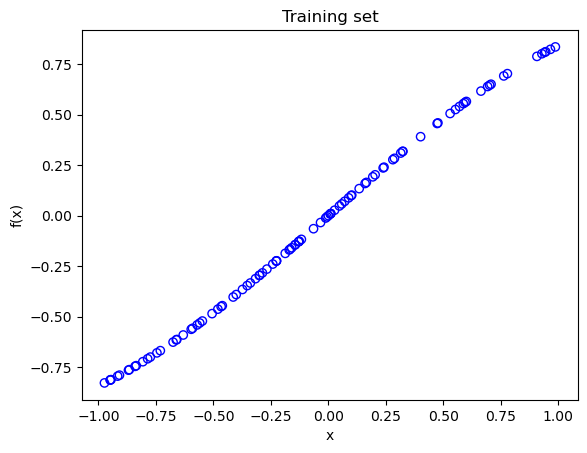

In [6]:
# plot data
plt.scatter(X,Y,facecolors='none', edgecolors='b')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training set')
# plt.savefig('test_sin_1_measurement2_target.png')
plt.show()

## Set Device

In [7]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

## Define embedding layer

In [8]:
# define my own embedding layer
def myembedding(x,wires):
    qml.RY(x, wires=wires[1])

## Define the Hamiltonian matrix transformation layer

In [9]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

## Define ansatze

In [10]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [11]:
@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [12]:
num_layers=4
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
print(theta.shape)
print(theta)

(4, 1)
[[4.88836944]
 [0.84165911]
 [5.45956418]
 [4.70471016]]


In [13]:
quantum_net(theta,0)

tensor([0.98697577], requires_grad=True)

In [14]:
print(qml.draw(quantum_net)(theta,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     


## Add classical layer

In [15]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    # r1=quantum_net(theta,x)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    r1=quantum_net(theta,x)
    return r1

In [16]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

In [17]:
def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

## Model training
Using the Adam optimizer, we update the weights for 100 steps (this takes some time). More steps will lead to a better fit.

In [18]:
w=np.zeros(5,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [19]:
start=now()
print(start)

2023-07-26 00:41:03.163905


In [20]:
epochs=100
for e in range(1,epochs+1):
    
    (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,X,Y)

    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost} | w: {w}')

Epoch: 1 | Cost: [1.2755077] | w: [0. 0. 0. 0. 0.]
Epoch: 10 | Cost: [0.23222501] | w: [0. 0. 0. 0. 0.]
Epoch: 20 | Cost: [0.14776015] | w: [0. 0. 0. 0. 0.]
Epoch: 30 | Cost: [0.01668851] | w: [0. 0. 0. 0. 0.]
Epoch: 40 | Cost: [0.02293664] | w: [0. 0. 0. 0. 0.]
Epoch: 50 | Cost: [0.00372822] | w: [0. 0. 0. 0. 0.]
Epoch: 60 | Cost: [0.00306172] | w: [0. 0. 0. 0. 0.]
Epoch: 70 | Cost: [0.00199637] | w: [0. 0. 0. 0. 0.]
Epoch: 80 | Cost: [0.00097465] | w: [0. 0. 0. 0. 0.]
Epoch: 90 | Cost: [0.00081714] | w: [0. 0. 0. 0. 0.]
Epoch: 100 | Cost: [0.00065154] | w: [0. 0. 0. 0. 0.]


In [21]:
pred_train=np.array([classical_quantum_net(theta,w,x) for x in X])

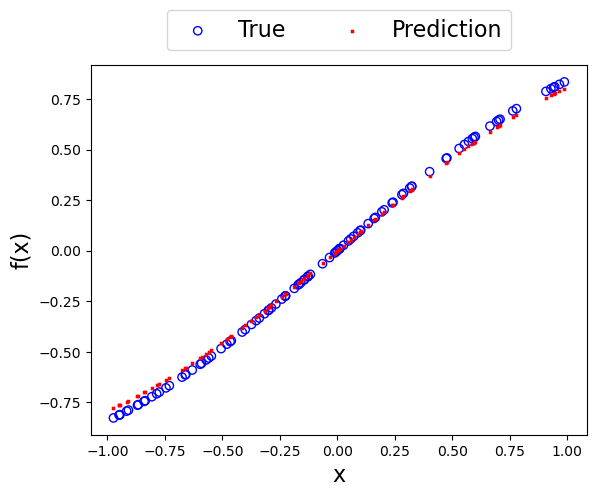

In [22]:
plt.figure()
plt.scatter(X,Y,facecolors='none', edgecolors='b', label='True')
plt.scatter(X,pred_train, color='red',marker="x",s=4,label='Prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('1_measurement2_train.png')
plt.show()

Differentiation

In [47]:
# print(theta)
m_x = np.random.uniform(-1,1,size=10,requires_grad=False)
# print(classical_quantum_net(theta,w,m_x))
# print(np.sin(m_x))
# print(np.cos(m_x))
# grad = qml.grad(quantum_net)(theta,m_x)
# psr = 0.7*np.sum(grad)
# print(psr)
print('============')
# print(np.sin(m_x))
# print(np.cos(m_x))
predict_mx = [classical_quantum_net(theta,w,x) for x in m_x]
# psr_arr = [np.sum(qml.grad(quantum_net)(theta,m_x)) for m_x in m_x]
# print(np.cos(m_x)/psr_arr)
# print(np.mean((psr_arr-np.cos(m_x))**2))
# print(psr_arr)

print(np.sin(m_x))
predict_mx = np.array(predict_mx).flatten()
print(np.mean(np.abs(np.sin(m_x)-predict_mx)))
# print('error = ',np.sum(np.abs(np.sin(m_x)-predict_mx)))

[ 0.7313544   0.80441472 -0.54945022  0.0834787   0.2237365  -0.57255829
 -0.63794711  0.77739023  0.18918192 -0.11932708]
0.022524517236964033


In [24]:
train_diff=np.abs(Y-pred_train)

In [25]:
np.max(train_diff)

tensor(1.62888112, requires_grad=True)

In [26]:
np.min(train_diff)

tensor(1.80140094e-05, requires_grad=True)

In [27]:
np.mean(train_diff)

tensor(0.53753498, requires_grad=True)

## Test error

In [28]:
X_test=np.linspace(-1,1,200)
Y_test=my_objective(X_test)
test_pred=[classical_quantum_net(theta,w,x) for x in X_test]

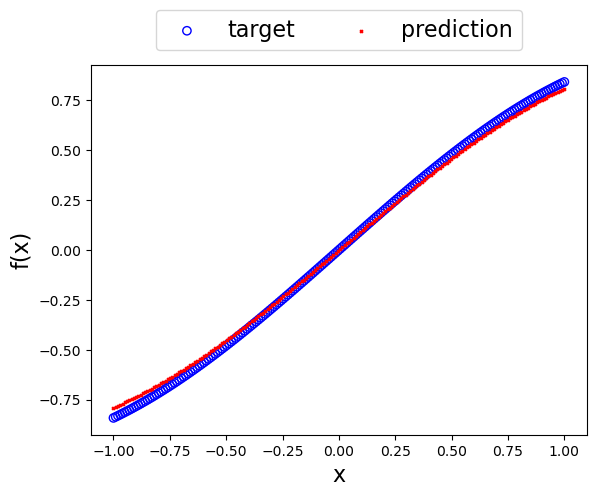

In [29]:
plt.figure()
plt.scatter(X_test,Y_test,facecolors='none', edgecolors='b',label='target')
plt.scatter(X_test,test_pred,color='red',marker="x",s=4,label='prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_test.png')
plt.show()

In [30]:
test_diff=np.abs(Y_test-test_pred)

In [31]:
np.max(test_diff)

tensor(1.6498322, requires_grad=True)

In [32]:
np.min(test_diff)

tensor(3.18670033e-05, requires_grad=True)

In [33]:
np.mean(test_diff)

tensor(0.59003593, requires_grad=True)